In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

#from utils.utils import *
from utils.data_loader import load_data
from utils.random_forest import RF_data_prep

In [2]:
final_clean_strained = load_data(db_level=0)
# Strain binary: 'C57B6' = 1, 'CBA/CaJ' = 0
final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB)'] >= 70]
final_clean_strained_80 = final_clean_strained[final_clean_strained['Level(dB)'] == 80]

In [3]:
final_clean_strained_avg = final_clean_strained.groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).agg(
    {'Amplitude': 'mean',
     'vx': 'first',
     'SynapsesPerIHC': 'mean', 
     'IHCs': 'mean',
     'OrphansPerIHC': 'mean',
     'Waveform': 'first',
     'WaveI': 'first',
     'Peaks': 'first',
     'Troughs': 'first',
     'Strain': 'first',
     'Sex': 'first',
     'Group': 'first',
     'Noise': 'mean',
     'Time (str)': 'first',
     'Time (hrs)': 'first',
     'Strain (binary)': 'first',
    }).reset_index()

In [4]:
final_clean_strained_70['Group'].value_counts(normalize=True, ascending=False)

Group
98dB 8wks post    0.117391
6wks ctrl         0.114493
98dB 24h post     0.086232
14wks ctrl        0.076812
90dB 2w post      0.072464
8wks ctrl         0.068841
94dB 24h post     0.064493
94dB 0h post      0.063043
98dB 2w post      0.058696
94dB 8wks post    0.054348
94dB 2w post      0.050725
90dB 0h post      0.044928
90dB 24h post     0.042754
14wks ctrl        0.036957
101dB 24h post    0.026087
94dB 0h post      0.021739
Name: proportion, dtype: float64

In [5]:
def split_by_mouse(data, 
                   split_on='Subject', 
                   stratify_on='Group', 
                   test_size=0.2, 
                   val_size=0.18, 
                   random_state=1,
                   return_idx=False):
    mice = data[[split_on, stratify_on]].drop_duplicates().set_index(split_on)

    train, test = train_test_split(mice.index, 
                                   test_size=test_size, 
                                   shuffle=True,
                                   stratify=mice[stratify_on], 
                                   random_state=random_state)

    train_indices = data[split_on].isin(train)
    test_indices = data[split_on].isin(test)

    train2, val = train_test_split(train,
                                   test_size=val_size,
                                   shuffle=True,
                                   stratify=mice.loc[train]['Group'],
                                   random_state=random_state)

    train2_indices = data[split_on].isin(train2)
    val_indices = data[split_on].isin(val)

    data['DataGroup'] = ''
    data.loc[train2_indices, 'DataGroup'] = 'Train'
    data.loc[val_indices, 'DataGroup'] = 'Validate'
    data.loc[test_indices, 'DataGroup'] = 'Test'
    if return_idx:
        return data, train_indices, train2_indices, val_indices, test_indices
    return data

In [6]:
final_clean_strained_avg, train_indices, train2_indices, val_indices, test_indices = split_by_mouse(final_clean_strained_avg, return_idx=True)

test_results = final_clean_strained_avg[test_indices].copy()

final_clean_strained_avg['DataGroup'].value_counts()

DataGroup
Train       3859
Test        1116
Validate     926
Name: count, dtype: int64

## Random forest with strain and normalization

In [24]:
X_train, X_test, y_train, y_test, preprocessor = RF_data_prep(final_clean_strained_avg) 

# For Random Forest
rf_params = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [5, 10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'rf__max_features': ['sqrt', 'log2', 0.3, 0.5]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=1))
])

# Use RandomizedSearchCV for efficiency
rf_search = RandomizedSearchCV(
    rf_pipeline, rf_params, 
    n_iter=50, cv=5, 
    scoring='neg_root_mean_squared_error',
    random_state=1, n_jobs=-1
)

rf_search.fit(X_train, y_train)
print(f"Best RF params: {rf_search.best_params_}")
r2 = r2_score(y_test, rf_search.predict(X_test))
errors1 = np.abs(y_test - rf_search.predict(X_test))
print(f"Best RF score: {-rf_search.best_score_:.3f}, R2 on test set: {r2:.3f}")
best_rf_model = rf_search.best_estimator_

Best RF params: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 15, 'rf__max_features': 'sqrt', 'rf__max_depth': 30}
Best RF score: 2.414, R2 on test set: 0.290


In [25]:
def plot_results(x, y, alpha=0.2, markersize=5, title='', color=None):
    if color is None:
        color = np.random.rand(3,)
        while np.mean(color) > 0.6:
            color = np.random.rand(3,)
    plt.plot(x, y, 'o', alpha=alpha, markersize=markersize, color=color)
    plt.plot([5, 20], [5, 20], 'k--', alpha=0.5)
    plt.axis('square')
    plt.xticks(np.arange(5, 21, 5)); plt.yticks(np.arange(5, 21, 5))
    plt.xlim(5, 20); plt.ylim(5, 20)
    plt.title(title)
    plt.xlabel('GT # Synapses')
    plt.ylabel('Predicted # Synapses')

10-15 dB, 542 samples, R2: -0.030, RMSE: 2.208
20-25 dB, 870 samples, R2: -0.101, RMSE: 2.407
30-35 dB, 907 samples, R2: -0.075, RMSE: 2.472
40-45 dB, 802 samples, R2: 0.032, RMSE: 2.492
50-55 dB, 721 samples, R2: 0.274, RMSE: 2.409
60-65 dB, 719 samples, R2: 0.384, RMSE: 2.760
70-75 dB, 724 samples, R2: 0.445, RMSE: 3.051
80-85 dB, 616 samples, R2: 0.375, RMSE: 2.849
All data, 5901 samples, R2: 0.290, RMSE: 2.572
Test set avg per mouse, R2: 0.447, RMSE: 2.680


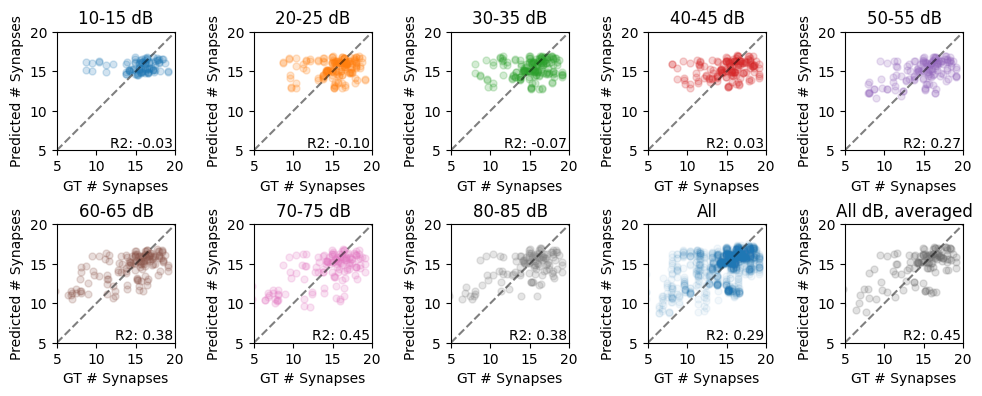

In [51]:
X_train, X_test, y_train, y_test, preprocessor = RF_data_prep(final_clean_strained_avg) 

dB_bins = [10, 20, 30, 40, 50, 60, 70, 80]
rf_pipeline = best_rf_model
plt.figure(figsize=(10,4))

color_palette = plt.cm.get_cmap('tab10', len(dB_bins)+2)
# iterate over dB levels:
for dB in dB_bins:
    data = final_clean_strained_avg[(final_clean_strained_avg['Level(dB)'] >= dB) &
                                   (final_clean_strained_avg['Level(dB)'] < dB + 10)]
    X = data[['Frequency(kHz)', 'Level(dB)',  'Amplitude', 'Strain (binary)']]
    y = data['SynapsesPerIHC']

    X_train1, X_test1, y_train1, y_test1 = X[data.DataGroup != 'Test'], X[data.DataGroup == 'Test'], y[data.DataGroup != 'Test'], y[data.DataGroup == 'Test']

    rf_pipeline.fit(X_train1, y_train1)
    r2 = r2_score(y_test1, rf_pipeline.predict(X_test1))
    rmse = np.sqrt(np.mean((y_test1 - rf_pipeline.predict(X_test1))**2))
    print(f"{dB}-{dB + 5} dB, {len(data)} samples, R2: {r2:.3f}, RMSE: {rmse:.3f}")
    plt.subplot(2, 5, dB//10)
    plot_results(y_test1, rf_pipeline.predict(X_test1), title=f'{dB}-{dB + 5} dB', color=color_palette(dB//10-1))
    # show R2 in lower right corner of plot:
    plt.text(19.75, 5, f'R2: {r2:.2f}', fontsize=10, horizontalalignment='right', verticalalignment='bottom')

# run on all data:
rf_pipeline.fit(X_train, y_train)
r2 = r2_score(y_test, rf_pipeline.predict(X_test))
rmse = np.sqrt(np.mean((y_test - rf_pipeline.predict(X_test))**2))
print(f"All data, {len(final_clean_strained_avg)} samples, R2: {r2:.3f}, RMSE: {rmse:.3f}")
plt.subplot(2, 5, 9)
plot_results(y_test, rf_pipeline.predict(X_test), alpha=0.05, title=f'All', color=color_palette(-2))
plt.text(19.75, 5, f'R2: {r2:.2f}', fontsize=10, horizontalalignment='right', verticalalignment='bottom')

test_set = final_clean_strained_avg[final_clean_strained_avg['DataGroup'] == 'Test']
test_set['RF predictions'] = rf_pipeline.predict(X_test)

# Avg per mouse, freq:
test_set_avg = test_set[['Subject', 'Frequency(kHz)', 'SynapsesPerIHC', 'RF predictions']].groupby(['Subject', 'Frequency(kHz)']).mean().reset_index()
r2 = r2_score(test_set_avg['SynapsesPerIHC'], test_set_avg['RF predictions'])
rmse = np.sqrt(np.mean((test_set_avg['SynapsesPerIHC'] - test_set_avg['RF predictions'])**2))
print(f"Test set avg per mouse, R2: {r2:.3f}, RMSE: {rmse:.3f}")
plt.subplot(2, 5, 10)
plot_results(test_set_avg['SynapsesPerIHC'], test_set_avg['RF predictions'], title='All dB, averaged', color='dimgray')
plt.text(19.75, 5, f'R2: {r2:.2f}', fontsize=10, horizontalalignment='right', verticalalignment='bottom')

plt.tight_layout()
plt.show()

### Just making extra figures for a presentation here...

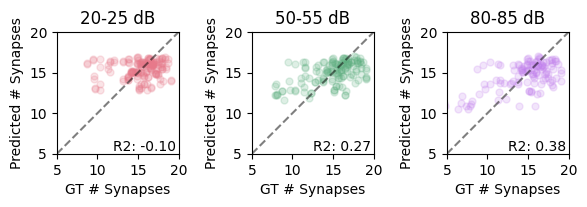

In [54]:
X_train, X_test, y_train, y_test, preprocessor = RF_data_prep(final_clean_strained_avg) 

dB_bins = [20, 50, 80]
color_list = ['#E7798A', '#5EAF80', '#C17EED']
count = 0

rf_pipeline = best_rf_model
plt.figure(figsize=(6,2))

# iterate over dB levels:
for dB in dB_bins:
    data = final_clean_strained_avg[(final_clean_strained_avg['Level(dB)'] >= dB) &
                                   (final_clean_strained_avg['Level(dB)'] < dB + 10)]
    X = data[['Frequency(kHz)', 'Level(dB)',  'Amplitude', 'Strain (binary)']]
    y = data['SynapsesPerIHC']

    X_train1, X_test1, y_train1, y_test1 = X[data.DataGroup != 'Test'], X[data.DataGroup == 'Test'], y[data.DataGroup != 'Test'], y[data.DataGroup == 'Test']

    rf_pipeline.fit(X_train1, y_train1)
    r2 = r2_score(y_test1, rf_pipeline.predict(X_test1))
    rmse = np.sqrt(np.mean((y_test1 - rf_pipeline.predict(X_test1))**2))
    plt.subplot(1, 3, count+1)
    plot_results(y_test1, rf_pipeline.predict(X_test1), title=f'{dB}-{dB + 5} dB', color=color_list[count])
    # show R2 in lower right corner of plot:
    plt.text(19.75, 5, f'R2: {r2:.2f}', fontsize=10, horizontalalignment='right', verticalalignment='bottom')
    count += 1

plt.tight_layout()
import os
plt.savefig(os.path.expanduser('~/Desktop/rf_results_by_db_limited.pdf'))

All data, 5901 samples, R2: 0.290, RMSE: 2.572
Test set avg per mouse, R2: 0.447, RMSE: 2.680


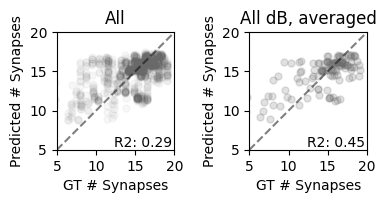

In [69]:
# run on all data:
plt.figure(figsize=(4,2))
rf_pipeline.fit(X_train, y_train)
r2 = r2_score(y_test, rf_pipeline.predict(X_test))
rmse = np.sqrt(np.mean((y_test - rf_pipeline.predict(X_test))**2))
print(f"All data, {len(final_clean_strained_avg)} samples, R2: {r2:.3f}, RMSE: {rmse:.3f}")
plt.subplot(1, 2, 1)
plot_results(y_test, rf_pipeline.predict(X_test), alpha=0.05, title=f'All', color='dimgray')
plt.text(19.75, 5, f'R2: {r2:.2f}', fontsize=10, horizontalalignment='right', verticalalignment='bottom')

test_set = final_clean_strained_avg[final_clean_strained_avg['DataGroup'] == 'Test']
test_set['RF predictions'] = rf_pipeline.predict(X_test)

# Avg per mouse, freq:
test_set_avg = test_set[['Subject', 'Frequency(kHz)', 'SynapsesPerIHC', 'RF predictions']].groupby(['Subject', 'Frequency(kHz)']).mean().reset_index()
r2 = r2_score(test_set_avg['SynapsesPerIHC'], test_set_avg['RF predictions'])
rmse = np.sqrt(np.mean((test_set_avg['SynapsesPerIHC'] - test_set_avg['RF predictions'])**2))
print(f"Test set avg per mouse, R2: {r2:.3f}, RMSE: {rmse:.3f}")
plt.subplot(1, 2, 2)
plot_results(test_set_avg['SynapsesPerIHC'], test_set_avg['RF predictions'], title='All dB, averaged', color='dimgray')
plt.text(19.75, 5, f'R2: {r2:.2f}', fontsize=10, horizontalalignment='right', verticalalignment='bottom')

plt.tight_layout()
import os
plt.show()
#plt.savefig(os.path.expanduser('~/Desktop/rf_results_by_db_avg.pdf'))

## Different model format: give amplitude at ALL dB values as input:

In [89]:
reformatted = (
    final_clean_strained_avg.pivot_table(
        index=["Subject", "Frequency(kHz)"],
        columns="Level(dB)",
        values="Amplitude"
    )
    .rename_axis(columns="Level_dB")
    .add_prefix("Amp_")
)

# Add Synapses column (constant per Subject/Freq)
synapses = (
    final_clean_strained_avg.groupby(["Subject", "Frequency(kHz)"])["SynapsesPerIHC"]
    .mean()
)
groups = (
    final_clean_strained_avg.groupby(["Subject", "Frequency(kHz)"])[["DataGroup", "Strain (binary)"]]
    .first()
)

# Combine
reformatted = reformatted.join(synapses).join(groups)

# fill NaNs with interpolated/extrapolated values:
amp_cols = [c for c in reformatted.columns if c.startswith("Amp_")]
reformatted[amp_cols] = reformatted[amp_cols].interpolate(axis=1, limit_direction='both')
reformatted.reset_index(inplace=True)
reformatted.head()


,Subject,Frequency(kHz),Amp_10.0,Amp_15.0,Amp_20.0,Amp_25.0,Amp_30.0,Amp_35.0,Amp_40.0,Amp_45.0,Amp_50.0,Amp_55.0,Amp_60.0,Amp_65.0,Amp_70.0,Amp_75.0,Amp_80.0,SynapsesPerIHC,DataGroup,Strain (binary)
0,WPZ100,8.0,0.077961,0.077961,0.029777,0.090885,0.137358,0.296385,0.381854,0.519497,0.657141,0.773465,0.889789,0.958785,1.027781,1.330248,1.632715,15.892142,Train,1
1,WPZ100,11.3,0.050718,0.050718,0.000000,0.168245,0.302752,0.392846,0.477460,0.668926,0.860391,0.956947,1.053503,1.267143,1.480784,1.743019,2.005255,16.492360,Train,1
2,WPZ100,16.0,0.059556,0.077295,0.047106,0.121329,0.202553,0.426837,0.424367,0.526245,0.628123,0.835713,1.043303,1.367660,1.692017,2.043966,2.395915,17.564103,Train,1
3,WPZ100,22.6,0.063072,0.063072,0.060886,0.098964,0.223176,0.255710,0.359520,0.548261,0.731459,0.885069,1.038678,1.308136,1.577594,1.906418,2.235242,17.381424,Train,1
4,WPZ100,32.0,0.091900,0.091900,0.257800,0.321347,0.333101,0.498574,0.664046,0.841320,1.018594,1.230492,1.442390,1.607816,1.773242,2.044980,2.316719,18.314239,Train,1


In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = reformatted[['Frequency(kHz)', 'Strain (binary)'] + amp_cols]
y = reformatted['SynapsesPerIHC']

X_train, X_test, y_train, y_test = X[reformatted.DataGroup != 'Test'], X[reformatted.DataGroup == 'Test'], y[reformatted.DataGroup != 'Test'], y[reformatted.DataGroup == 'Test']

preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), ['Frequency(kHz)'] + amp_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (binary)'])
    ])


Best RF params: {'rf__n_estimators': 500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': None}
Best RF score: 2.663, R2 train: 0.916, R2 test: 0.480


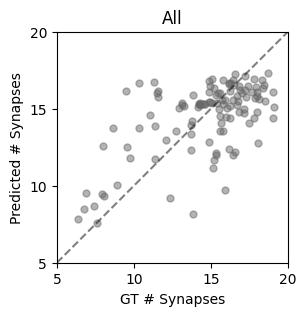

In [91]:
# For Random Forest
rf_params = {
    'rf__n_estimators': [50, 100, 300, 500, 1000],
    'rf__max_depth': [10, 15, 30, 40, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['sqrt', 'log2', 0.3, 0.5]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=1))
])

# Use RandomizedSearchCV for efficiency
rf_search = RandomizedSearchCV(
    rf_pipeline, rf_params, 
    n_iter=50, cv=5, 
    scoring='neg_root_mean_squared_error', #'explained_variance', #'r2'
    random_state=1, n_jobs=-1
)

rf_search.fit(X_train, y_train)
print(f"Best RF params: {rf_search.best_params_}")
r2_train = r2_score(y_train, rf_search.predict(X_train))
r2 = r2_score(y_test, rf_search.predict(X_test))
errors1 = np.abs(y_test - rf_search.predict(X_test))
print(f"Best RF score: {-rf_search.best_score_:.3f}, R2 train: {r2_train:.3f}, R2 test: {r2:.3f}")
best_rf_model = rf_search.best_estimator_

plt.figure(figsize=(3,3))
plot_results(y_test, best_rf_model.predict(X_test), title=f'All', alpha=0.5, color='dimgray')
plt.show()

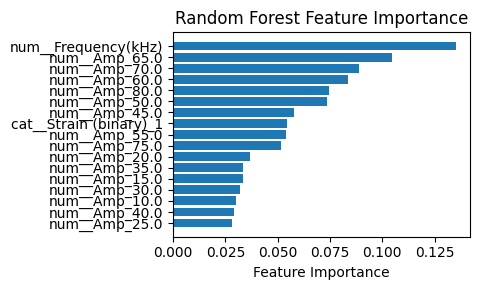

In [92]:
# Get feature importance 
feature_importance = best_rf_model.named_steps['rf'].feature_importances_
feature_names = best_rf_model.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(5, 3))
plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Permutation Importance Rankings:
                   Feature  Importance_Mean  Importance_Std
0      num__Frequency(kHz)         4.522546        1.155574
10           num__Amp_55.0         1.125709        0.346011
12           num__Amp_65.0         0.581919        0.232292
11           num__Amp_60.0         0.521503        0.122748
13           num__Amp_70.0         0.519534        0.201445
14           num__Amp_75.0         0.469399        0.182596
7            num__Amp_40.0         0.409162        0.146547
9            num__Amp_50.0         0.399860        0.248217
16  cat__Strain (binary)_1         0.309276        0.168197
6            num__Amp_35.0         0.196579        0.092021
1            num__Amp_10.0         0.179523        0.403583
8            num__Amp_45.0         0.133350        0.060814
15           num__Amp_80.0         0.092861        0.113505
5            num__Amp_30.0         0.057029        0.035530
4            num__Amp_25.0        -0.085386        0.078366
2     

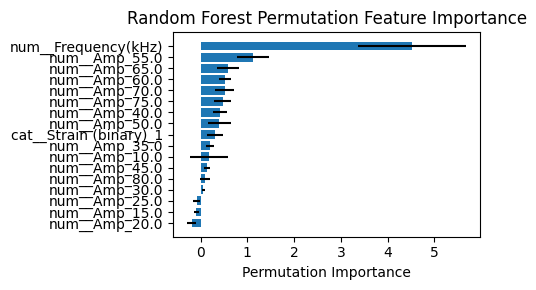

In [93]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on test set
perm_importance = permutation_importance(
    best_rf_model, X_test, y_test, 
    n_repeats=10, random_state=42, 
    scoring='neg_mean_squared_error'
)

# Create permutation importance DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nPermutation Importance Rankings:")
print(perm_importance_df)

# Plot permutation importance with error bars
plt.figure(figsize=(5, 3))
plt.barh(range(len(perm_importance_df)), perm_importance_df['Importance_Mean'],
         xerr=perm_importance_df['Importance_Std'])
plt.yticks(range(len(perm_importance_df)), perm_importance_df['Feature'])
plt.xlabel('Permutation Importance')
plt.title('Random Forest Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

[Text(0, 0, 'num__Amp_25.0'), Text(0, 1, 'num__Amp_40.0'), Text(0, 2, 'num__Amp_10.0'), Text(0, 3, 'num__Amp_20.0'), Text(0, 4, 'num__Amp_15.0'), Text(0, 5, 'num__Amp_30.0'), Text(0, 6, 'num__Amp_35.0'), Text(0, 7, 'num__Amp_75.0'), Text(0, 8, 'num__Amp_55.0'), Text(0, 9, 'num__Amp_45.0'), Text(0, 10, 'num__Amp_80.0'), Text(0, 11, 'num__Amp_60.0'), Text(0, 12, 'num__Amp_70.0'), Text(0, 13, 'num__Amp_50.0'), Text(0, 14, 'num__Amp_65.0'), Text(0, 15, 'num__Frequency(kHz)'), Text(0, 16, 'cat__Strain (binary)_1')]


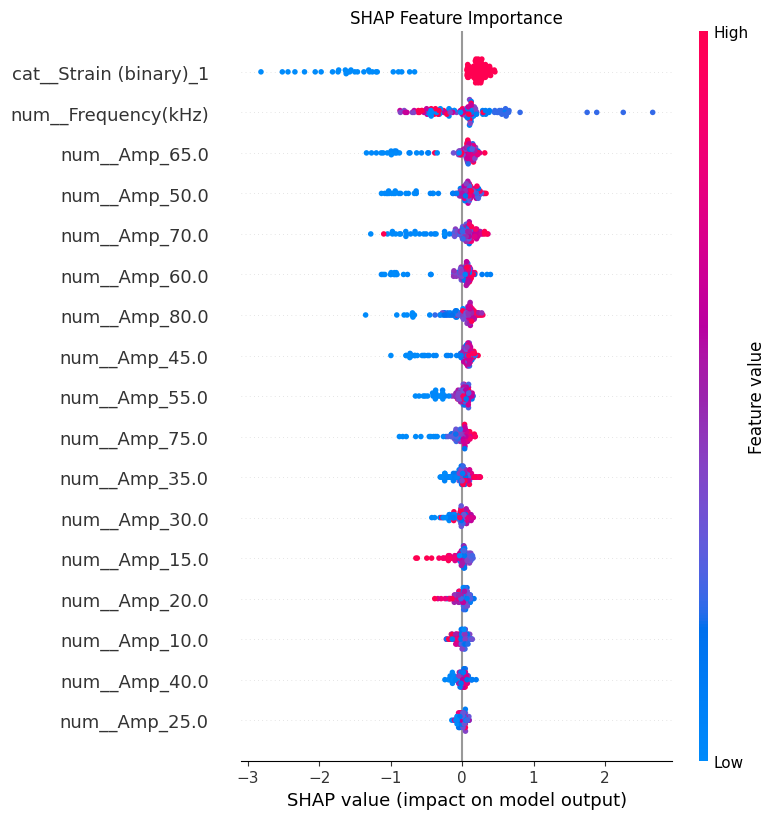

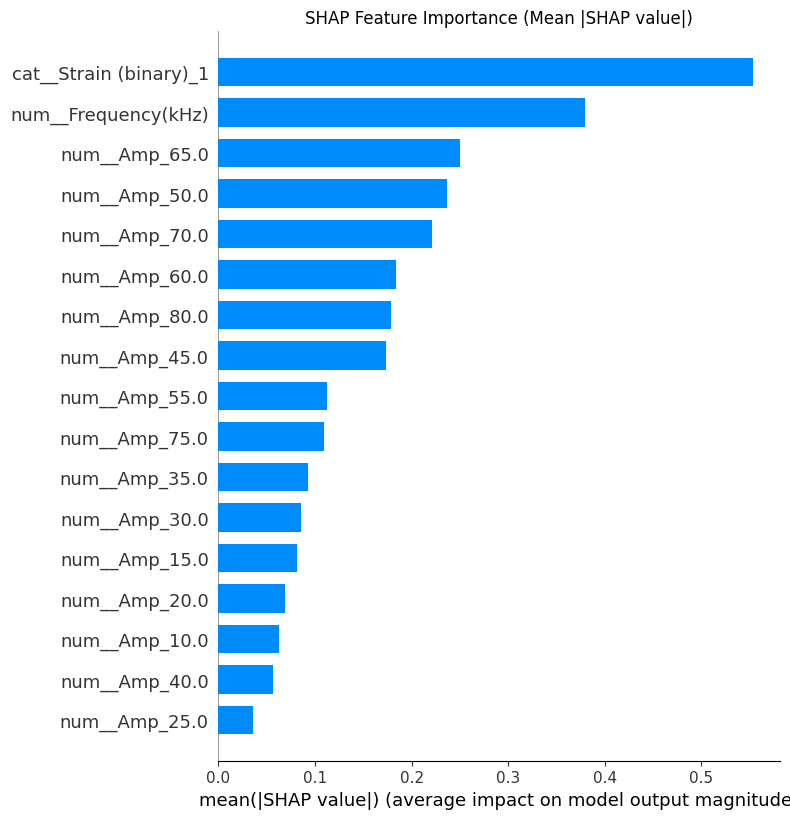

In [94]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf_model.named_steps['rf'])

# Get preprocessed test data
X_test_preprocessed = best_rf_model.named_steps['preprocessor'].transform(X_test)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_preprocessed)

# Summary plot
plt.figure(figsize=(5, 4))
shap.summary_plot(shap_values, X_test_preprocessed, 
                  feature_names=feature_names, show=False)
plt.title('SHAP Feature Importance')
print(plt.gca().get_yticklabels())
#plt.gca().set_yticklabels(feature_names, rotation=45)
plt.tight_layout()
plt.show()

# Bar plot of mean absolute SHAP values
plt.figure(figsize=(5, 4))
shap.summary_plot(shap_values, X_test_preprocessed, 
                  feature_names=feature_names, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)')
plt.tight_layout()
plt.show()

In [18]:
# Calculate SHAP interaction values (this can be computationally expensive)
shap_interaction_values = explainer.shap_interaction_values(X_test_preprocessed)

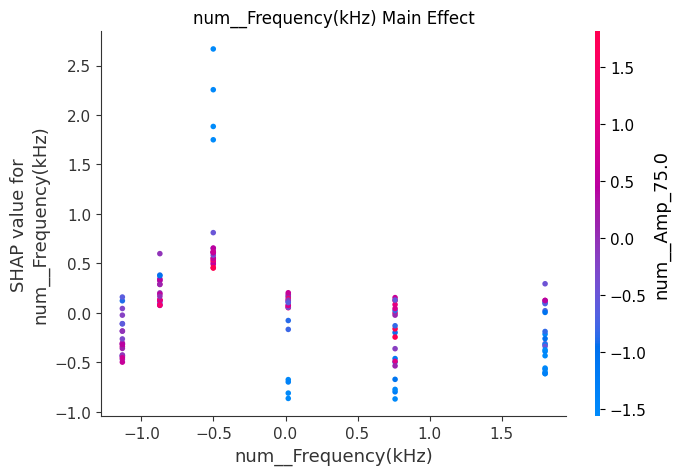

<Figure size 300x300 with 0 Axes>

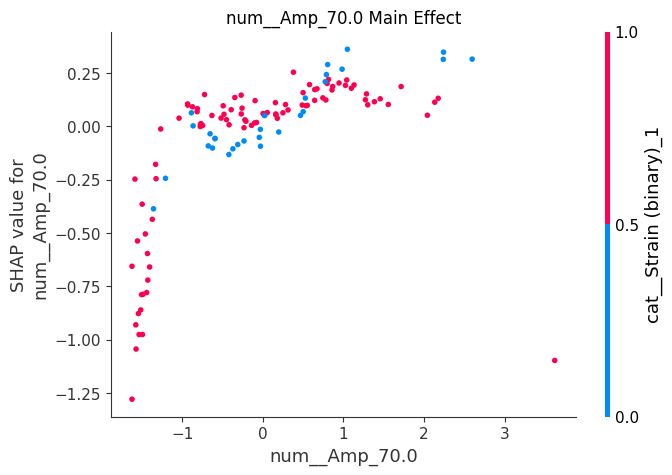

<Figure size 300x300 with 0 Axes>

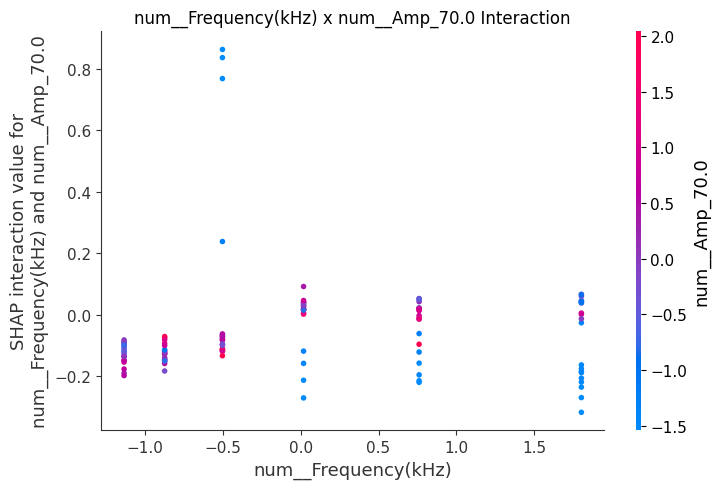

In [20]:
ft1 = 0
ft2 = 2
top_features = importance_df['Feature'].values
feature_idx1 = list(feature_names).index(top_features[ft1])
feature_idx2 = list(feature_names).index(top_features[ft2])

# Main effects and interaction using shap.dependence_plot
shap.dependence_plot(
    feature_idx1, shap_values, X_test_preprocessed, feature_names=feature_names, show=False
)
plt.title(f'{top_features[ft1]} Main Effect')
plt.figure(figsize=(3, 3))
shap.dependence_plot(
    feature_idx2, shap_values, X_test_preprocessed, feature_names=feature_names, show=False
)
plt.title(f'{top_features[ft2]} Main Effect')
plt.figure(figsize=(3, 3))
shap.dependence_plot(
    (feature_idx1, feature_idx2), shap_interaction_values, X_test_preprocessed, feature_names=feature_names, show=False, interaction_index=feature_idx2
)
plt.title(f'{top_features[ft1]} x {top_features[ft2]} Interaction')

plt.tight_layout()
plt.show()

<Figure size 1500x400 with 0 Axes>

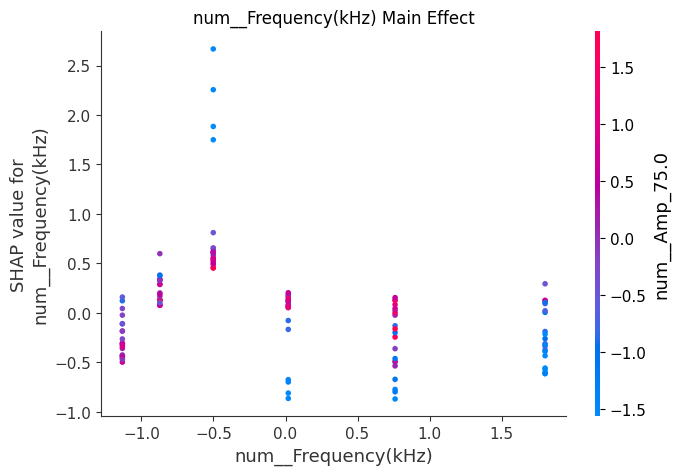

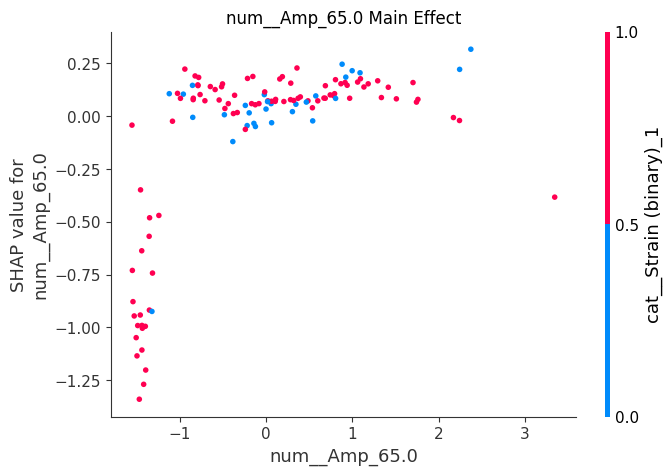

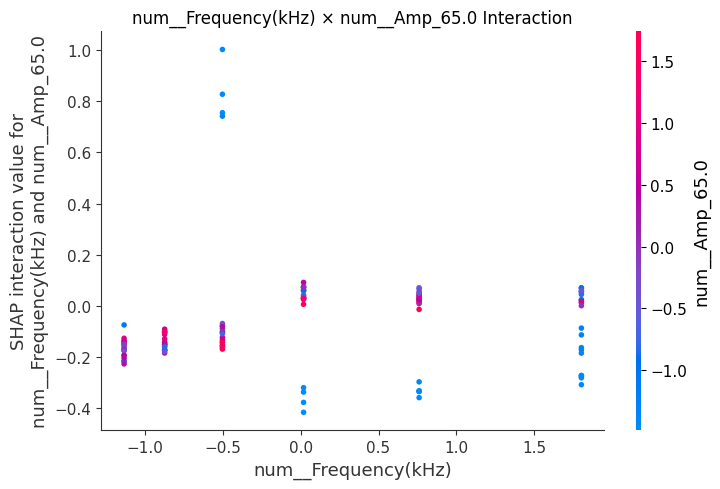

In [21]:
# Calculate SHAP interaction values (this can be computationally expensive)
shap_interaction_values = explainer.shap_interaction_values(X_test_preprocessed)

# Plot interaction between two specific features
# Let's say we want to see interaction between the two most important features
top_features = importance_df.head(2)['Feature'].values
feature_idx1 = list(feature_names).index(top_features[0])
feature_idx2 = list(feature_names).index(top_features[1])

# Main effects and interaction using shap.dependence_plot
plt.figure(figsize=(15, 4))

shap.dependence_plot(
    feature_idx1, shap_values, X_test_preprocessed, feature_names=feature_names, show=False
)
plt.title(f'{top_features[0]} Main Effect')

shap.dependence_plot(
    feature_idx2, shap_values, X_test_preprocessed, feature_names=feature_names, show=False
)
plt.title(f'{top_features[1]} Main Effect')

shap.dependence_plot(
    (feature_idx1, feature_idx2), shap_interaction_values, X_test_preprocessed, feature_names=feature_names, show=False, interaction_index=feature_idx2
)
plt.title(f'{top_features[0]} × {top_features[1]} Interaction')

plt.tight_layout()
plt.show()

rf R²: 0.480
gb R²: 0.347
et R²: 0.489
elastic R²: 0.120
svr R²: 0.264
Ensemble R²: 0.425


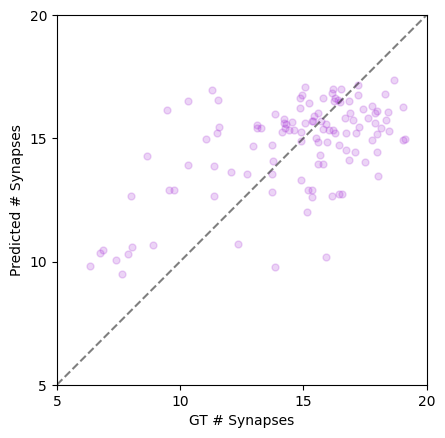

In [22]:
# Create ensemble of different models
models = {
    'rf': best_rf_model[1], #RandomForestRegressor(n_estimators=200, max_depth=15, random_state=1),
    'gb': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=1),
    'et': ExtraTreesRegressor(n_estimators=200, random_state=1),
    'elastic': ElasticNet(alpha=0.1, random_state=1),
    'svr': SVR(kernel='rbf', C=1.0, gamma='scale')
}

# Train all models and average predictions
ensemble_preds = np.zeros(len(X_test))
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    ensemble_preds += pred
    print(f'{name} R²: {r2_score(y_test, pred):.3f}')

ensemble_preds /= len(models)
ensemble_r2 = r2_score(y_test, ensemble_preds)
print(f'Ensemble R²: {ensemble_r2:.3f}')

plot_results(y_test, ensemble_preds)
